In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.linear_model import LinearRegression
from fill_data_gap_helpers import *

pd.set_option('display.max_rows', 8)
!

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_estimated_data_plus_covariates_with_nutrient_3_14_2021.csv'
# path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_estimated_data_plus_covariates_3_14_2021.csv'

In [3]:
df = pd.read_csv(path)
df = df[['location_id','location_name', 'vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_vehicle', 'nutrient',
       'percent_of_population_eating_fortified_vehicle',
       'sodium', 'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id']]
df.head()

,location_id,location_name,vehicle,percent_of_population_eating_industrially_produced_vehicle,percent_of_population_eating_vehicle,nutrient,percent_of_population_eating_fortified_vehicle,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all,parent_id
0,161.0,Bangladesh,oil,88.4,95.0,vitamin a,42.849572,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
1,161.0,Bangladesh,oil,88.4,95.0,vitamin d,0.000000,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
2,161.0,Bangladesh,oil,88.4,89.0,vitamin a,42.849572,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
3,161.0,Bangladesh,oil,88.4,89.0,vitamin d,0.000000,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
4,161.0,Bangladesh,oil,88.4,75.0,vitamin a,42.849572,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159


In [4]:
npar = df.parent_id.nunique()
parent_map = {i:j for (i,j) in zip(df.parent_id.unique(),np.random.choice(npar, size = npar, replace = False))}

In [5]:
df.parent_id = df.parent_id.map(parent_map)

## Globals

In [6]:
estimation_vars = ['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle']
shift = .01 #for logit transform

In [7]:
nlocs = df.location_name.nunique()
loc_map = {i:j for (i,j) in zip(df.location_name.unique(),np.random.choice(nlocs, size = nlocs, replace = False))}

nvehs = df.vehicle.nunique()
vcl_map = {i:j for (i,j) in zip(df.vehicle.unique(),np.random.choice(nvehs, size = nvehs, replace = False))}

nnutrs = df.nutrient.nunique()
nut_map = {i:j for (i,j) in zip(df.nutrient.unique(),np.random.choice(nnutrs, size = nnutrs, replace = False))}

## Percent of population eating vehicle

In [8]:
from sklearn import ensemble
from sklearn.linear_model import ElasticNet

In [9]:
def setupReg(df, vehicle, use_logit):
    if use_logit:
        df = shift_logit(df, estimation_vars, shift)


    s = df[(df.vehicle==vehicle)]

    # if we have no data on strongest predictors, drop
    keep_these = ~((s.percent_of_population_eating_industrially_produced_vehicle.isna())
                     & (s.percent_of_population_eating_fortified_vehicle.isna()))

    ##TODO: TRY GUESS MEAN VAL AFTER DROPPING THE ABOVE LINE
    s.nutrient = s.nutrient.map(nut_map)
    s = guess_mean_val(s, grouped_on = 'vehicle', cols = ['percent_of_population_eating_industrially_produced_vehicle',
                                                           'nutrient','percent_of_population_eating_fortified_vehicle',
                                                           'sodium', 'whole_grains', 'sdi', 'hh_salt',
                                                           'fao_maize_and_products','fao_rice_and_products',
                                                           'fao_wheat_and_products', 'fao_oil_all'])

    s = s.drop(columns=['vehicle'])

#     s.nutrient = s.nutrient.map(nut_map)

    #     s['percent_of_population_eating_industrially_produced_vehicle'] = s.groupby('location_name').transform('mean').percent_of_population_eating_industrially_produced_vehicle
    #     s['percent_of_population_eating_fortified_vehicle'] = s.groupby('location_name').transform('mean').percent_of_population_eating_fortified_vehicle

    r = s[keep_these & s.percent_of_population_eating_vehicle.notna()]

    full_locs = s.location_name.tolist()
    notna_locs = r.location_name.tolist()

    s = s.drop(columns=['location_name','location_id'])
    r = r.drop(columns=['location_name','location_id'])
    
    X_full = np.array(s.drop(columns='percent_of_population_eating_vehicle'))
    y_full = np.array(s.percent_of_population_eating_vehicle)

    X = np.array(r.drop(columns='percent_of_population_eating_vehicle'))
    y = np.array(r.percent_of_population_eating_vehicle)

    return X, y, X_full, y_full, full_locs, notna_locs

In [10]:
def runReg(X, y, notna_locs, holdout_loc):
    
    params = {'n_estimators': 800,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'lad'}
    
    #run the regression on datapoints from all locations except one
    N = y.shape[0]
    select = [i for i in range(len(notna_locs)) if notna_locs[i]!=loc]
    
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X[select], y[select])
    
    # predict for heldout location
    holdout = np.array([i for i in range(N) if i not in select])
    preds = reg.predict(X[holdout])
    
    return holdout, preds

In [11]:
def plotReg(preds, holdout, use_logit, vehicle):
    if use_logit:
        backtransf_preds = (expit(preds) + shift) * 100
        backtransf_y = (expit(y[holdout]) + shift) * 100
        plt.scatter(backtransf_y, backtransf_preds)

        l,r,b,t = plt.axis()
        lb = min(0,l,b)
        ub = max(100,r,t)
        plt.plot([lb,ub], [lb,ub], 'k--')

        plt.title(f"out of sample validation: \npct of population that eats {vehicle}, using shifted logit tranform", fontsize = 15)    
    else:
        plt.scatter(y[holdout], preds)
        
        l,r,b,t = plt.axis()
        lb = min(0,l,b)
        ub = max(100,r,t)
        plt.plot([lb,ub], [lb,ub], 'k--')
        
        plt.title(f"out of sample validation: \npct of population that eats {vehicle}", fontsize = 15)
    plt.xlabel(f"Extracted value: pct of pop eating {vehicle}")
    plt.ylabel(f"Predicted value: pct of pop eating {vehicle}")

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Burkina Faso


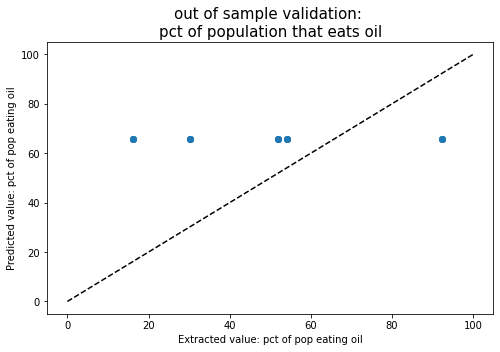

Cameroon


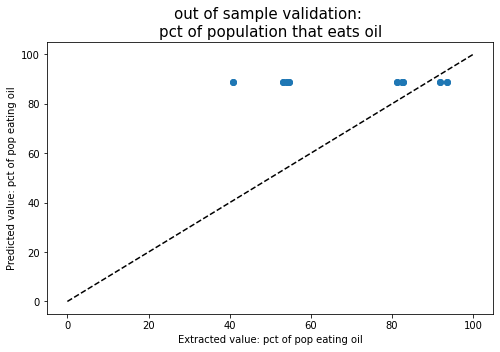

Côte d'Ivoire


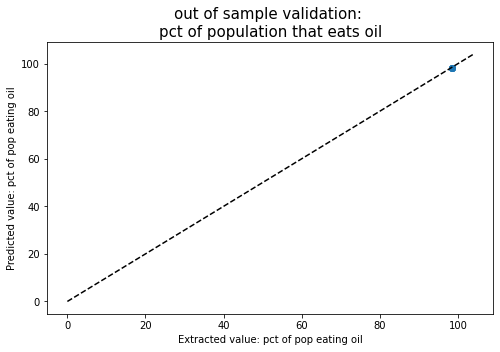

Democratic Republic of the Congo


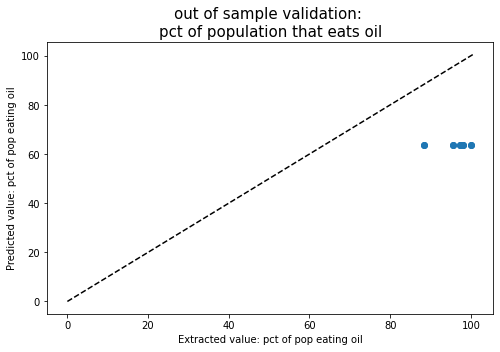

Ethiopia


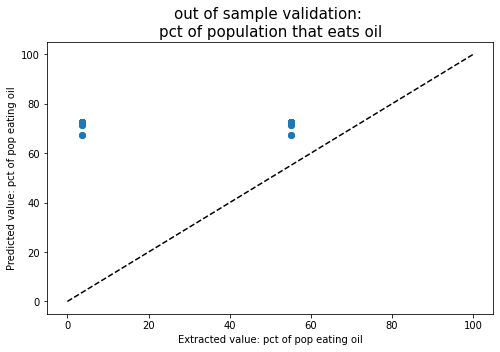

Ghana


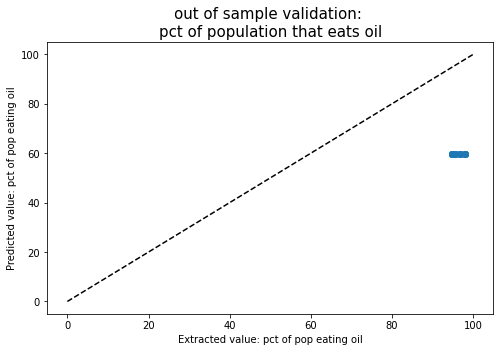

India


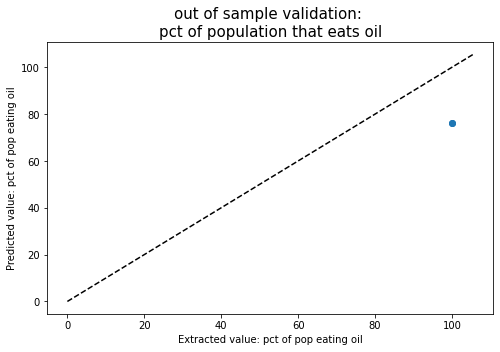

Kenya


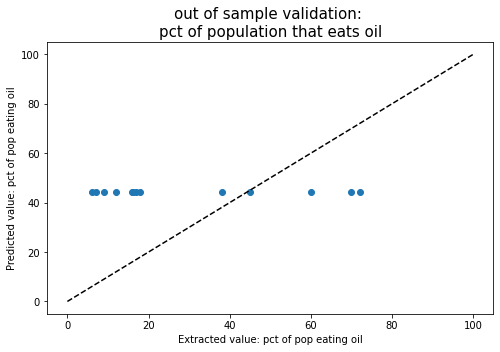

Mozambique


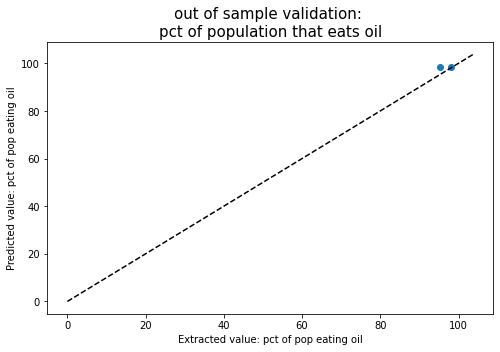

Myanmar


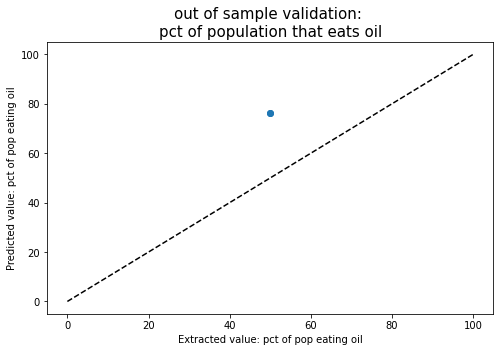

Nepal


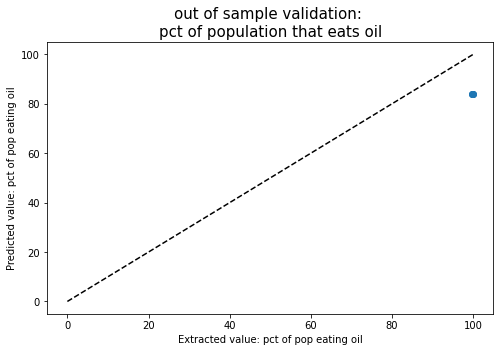

Niger


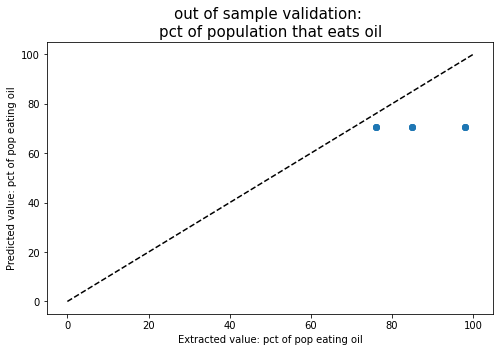

Nigeria


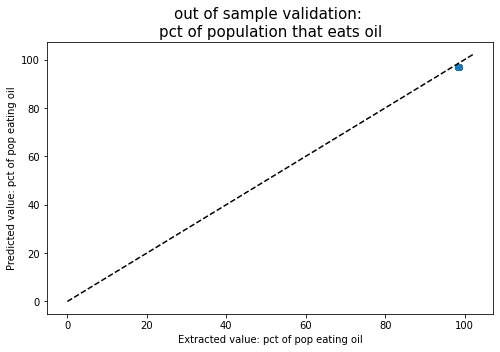

Pakistan


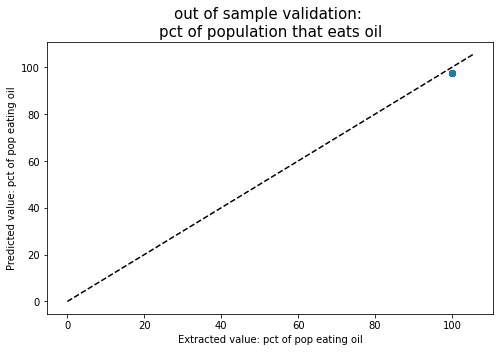

Uganda


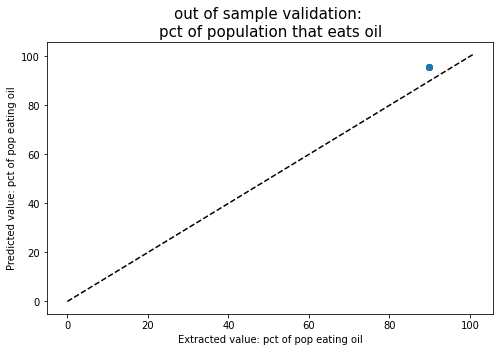

United Republic of Tanzania


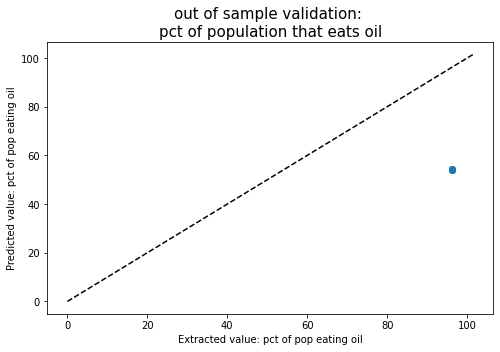

Viet Nam


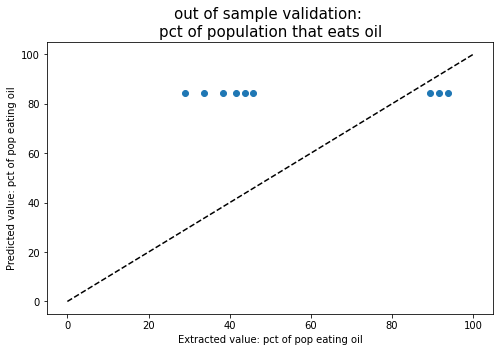

In [12]:
X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, "oil", use_logit = False)

loc = np.unique(notna_locs)[0]
for loc in np.unique(notna_locs)[1:]:
    print(loc)
    holdout, preds = runReg(X, y, notna_locs, loc)
    fig = plt.figure(figsize=(8,5))
    plotReg(preds, holdout, False, "oil")
    plt.show()

In [13]:
X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, "oil", use_logit = False)

loc = np.unique(notna_locs)[0]
holdout, preds = runReg(X, y, notna_locs, loc)

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, "oil", use_logit = False)
total = pd.DataFrame()

loc = np.unique(notna_locs)[0]
for loc in np.unique(notna_locs)[1:]:
    holdout, preds = runReg(X, y, notna_locs, loc)
    sub = pd.DataFrame({'holdout':y[holdout],'preds':preds,'location_name':loc})
    total = total.append(sub)

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


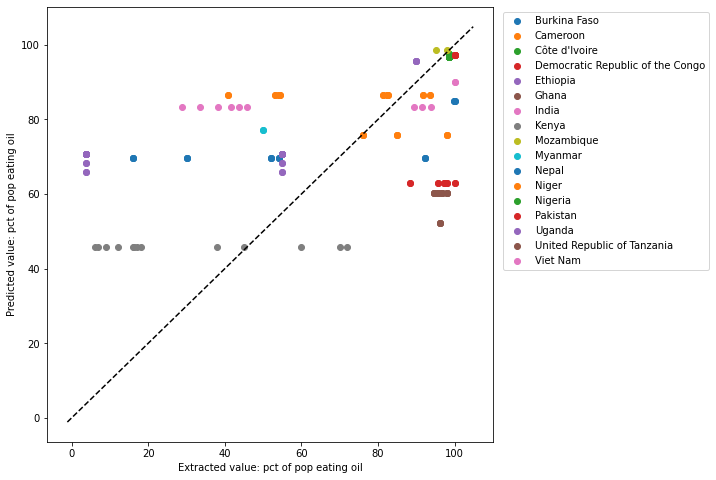

In [16]:
vehicle="oil"
fig = plt.figure(figsize=(8,8))
for loc in total.location_name.unique():
    plt.scatter(total[total.location_name==loc].holdout,total[total.location_name==loc].preds, label= loc)
l,r,b,t = plt.axis()
lb = min(0,l,b)
ub = max(100,r,t)

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.xlabel(f"Extracted value: pct of pop eating {vehicle}")
plt.ylabel(f"Predicted value: pct of pop eating {vehicle}")
plt.plot([lb,ub], [lb,ub], 'k--')

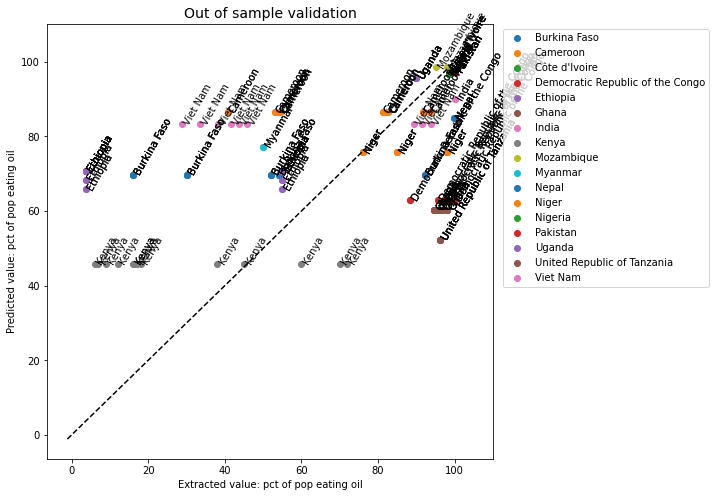

In [17]:
fig = plt.figure(figsize=(8,8))
for loc in total.location_name.unique():
    plt.scatter(total[total.location_name==loc].holdout,total[total.location_name==loc].preds, label= loc)
    for i in range(len(total[total.location_name==loc])):
        plt.annotate(loc, (total[total.location_name==loc].iloc[i].holdout,
                           total[total.location_name==loc].iloc[i].preds),
                    rotation=60)
l,r,b,t = plt.axis()
lb = min(0,l,b)
ub = max(100,r,t)

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.annotate("hello", (10,10))

plt.xlabel(f"Extracted value: pct of pop eating {vehicle}")
plt.ylabel(f"Predicted value: pct of pop eating {vehicle}")
plt.title("Out of sample validation", fontsize = 14)
plt.plot([lb,ub], [lb,ub], 'k--')

In [18]:
def estimate_nans(df, vehicle, use_logit, clip = True):
    
    # format for regression
    X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, vehicle, use_logit = False)
    
    # run regression
    params = {'n_estimators': 800,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'lad'}
    
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X, y)
    
    # predict out
    preds = reg.predict(X_full)
    
    # populate missings with estimates
    y_full[np.isnan(y_full)] = preds[np.isnan(y_full)] 
    
    if use_logit:
        y_full = (expit(y_full) + shift) * 100
    
    if clip:
        y_full = np.clip(y_full, 0, 100)
    
    return pd.DataFrame({'location_name':full_locs,'vehicle':vehicle,'percent_of_population_eating_vehicle':y_full})

In [19]:
estimates = estimate_nans(df, vehicle = "oil", use_logit = False, clip = True)

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
estimates = estimates.groupby(['location_name','vehicle']).mean().reset_index()

In [21]:
estimates.head()

,location_name,vehicle,percent_of_population_eating_vehicle
0,Angola,oil,91.891122
1,Bangladesh,oil,79.200000
2,Burkina Faso,oil,48.906000
3,Cameroon,oil,68.790000
4,China,oil,82.127836


In [23]:
estimates[estimates.location_name=="South Africa"]

,location_name,vehicle,percent_of_population_eating_vehicle
20,South Africa,oil,99.176923


In [ ]:
save_oil_estimates = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_regression_estimates_3_15_2021.csv'
estimates.to_csv(save_oil_estimates, index = False)

In [ ]:
estimates = estimates.groupby(['location_name']).mean()

vals = df.loc[(df.vehicle=="oil") & (df.percent_of_population_eating_vehicle.notna()),['location_name','percent_of_population_eating_vehicle']]

estimates = vals.merge(estimates, on = ['location_name'], how = 'outer')

In [ ]:
estimates.head() 

In [ ]:
fig = plt.figure(figsize=(8,8))
for loc in total.location_name.unique():
    plt.scatter(estimates[estimates.location_name==loc].percent_of_population_eating_vehicle_x,
                estimates[estimates.location_name==loc].percent_of_population_eating_vehicle_y, label = loc)
l,r,b,t = plt.axis()
lb = min(0,l,b)
ub = max(100,r,t)

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.xlabel(f"Extracted value: pct of pop eating {vehicle}")
plt.ylabel(f"Predicted value: pct of pop eating {vehicle}")
plt.title("Estimate error when  using all data", fontsize = 14)
plt.plot([lb,ub], [lb,ub], 'k--')

In [ ]:
estimates

In [ ]:
df.vehicle.unique()

In [ ]:
for vehicle in ['wheat flour', 'maize flour', 'bouillon', 'salt', 'rice']:
    print(vehicle)
    X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, vehicle, use_logit = False)
    total = pd.DataFrame()

    loc = np.unique(notna_locs)[0]
    for loc in np.unique(notna_locs)[1:]:
        holdout, preds = runReg(X, y, notna_locs, loc)
        sub = pd.DataFrame({'holdout':y[holdout],'preds':preds,'location_name':loc})
        total = total.append(sub)
        
    fig = plt.figure(figsize=(8,8))
    for loc in total.location_name.unique():
        plt.scatter(total[total.location_name==loc].holdout,total[total.location_name==loc].preds, label= loc)
    l,r,b,t = plt.axis()
    lb = min(0,l,b)
    ub = max(100,r,t)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.xlabel(f"Extracted value: pct of pop eating {vehicle}")
    plt.ylabel(f"Predicted value: pct of pop eating {vehicle}")
    plt.plot([lb,ub], [lb,ub], 'k--')
    plt.title(f"Out of sample validation (by country): {vehicle}", fontsize = 14)
    plt.show()

In [ ]:
# now want to estimate south africa oil